In [72]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 15,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

warmup_time = 5.0
num_runs = 15

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

v = '019'
perrs = [0, 5, 10]
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'

lying_intensity = 100


In [73]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [74]:
def get_interdetection_time(method, num_nodes, lying_intensity, per):
    all_inter_detection_times = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'{results_path}/res/v{v}/{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.csv')
            df = df.filter(pl.col("detected_node").is_in(malicious_nodes))
            # print(df)
            # For each malicious node, calculate inter-detection times
            for node_id in malicious_nodes:
                node_df = df.filter(pl.col("detected_node") == node_id)
                # Sort by detection time
                detection_times = node_df.sort("detected_at")["detected_at"].to_numpy()

                # Filter out detections within 0.5 seconds of the previous detection
                if len(detection_times) > 1:
                    filtered_detections = [detection_times[0]]
                    for i in range(1, len(detection_times)):
                        if detection_times[i] - filtered_detections[-1] >= 0.5:
                            filtered_detections.append(detection_times[i])
                else:
                    filtered_detections = detection_times

                # Compute inter-detection times using np.diff
                inter_detection_times = np.diff(filtered_detections)
                all_inter_detection_times.extend(inter_detection_times)
        except:
            # print(f"Error encountered: {str(e)}")
            pass

    # Calculate the histogram
    hist, bin_edges = np.histogram(all_inter_detection_times, bins=np.arange(0, 120, 0.1))
    hist = hist / np.sum(hist)
    # Calculate the CDF
    cdf = np.cumsum(hist) * 100

    return bin_edges, cdf

In [75]:
bin_edges, ART_0 = get_interdetection_time('ART', num_malicios, lying_intensity, 0)
_, ART_5 = get_interdetection_time('ART', num_malicios, lying_intensity, 5)
_, ART_10 = get_interdetection_time('ART', num_malicios, lying_intensity, 10)

_, MGT_0 = get_interdetection_time('MGT', num_malicios, lying_intensity, 0)
_, MGT_5 = get_interdetection_time('MGT', num_malicios, lying_intensity, 5)
_, MGT_10 = get_interdetection_time('MGT', num_malicios, lying_intensity, 10)

_, PEPT_0 = get_interdetection_time('PEPT', num_malicios, lying_intensity, 0)
_, PEPT_5 = get_interdetection_time('PEPT', num_malicios, lying_intensity, 5)
_, PEPT_10 = get_interdetection_time('PEPT', num_malicios, lying_intensity, 10)

_, REPT_0 = get_interdetection_time('REPT', num_malicios, lying_intensity, 0)
_, REPT_5 = get_interdetection_time('REPT', num_malicios, lying_intensity, 5)
_, REPT_10 = get_interdetection_time('REPT', num_malicios, lying_intensity, 10)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) /2

/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/ctypeslib.py:526: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


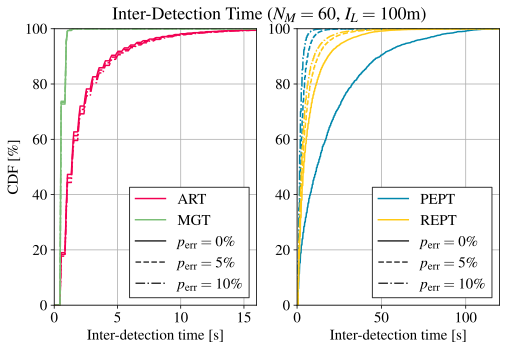

In [76]:
ART_COLOR = color_C2
MGT_COLOR = color_M1
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, axes = plt.subplots(ncols=2, figsize=(8,5))

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(bin_centers, ART_0, '-', color=ART_COLOR, label="ART")
ax1.plot(bin_centers, ART_5, '--', color=ART_COLOR)
ax1.plot(bin_centers, ART_10, '-.', color=ART_COLOR)

ax1.plot(bin_centers, MGT_0, '-', color=MGT_COLOR, label="MGT")
ax1.plot(bin_centers, MGT_5, '--', color=MGT_COLOR)
ax1.plot(bin_centers, MGT_10, '-.', color=MGT_COLOR)
ax1.set_ylabel('CDF [\%]')
ax1.set_xlabel('Inter-detection time [s]')
ax1.grid()

ax1.set_ylim([0,100])
ax1.set_xlim([0,16])

ax1.plot([],[], '-', color='#333', label='$p_\mathrm{{err}} = 0$\%')
ax1.plot([],[], '--', color='#333', label='$p_\mathrm{{err}} = 5$\%')
ax1.plot([],[], '-.', color='#333', label='$p_\mathrm{{err}} = 10$\%')

leg = ax1.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

ax2.plot(bin_centers, PEPT_0, '-', color=PEPT_COLOR, label="PEPT")
ax2.plot(bin_centers, PEPT_5, '--', color=PEPT_COLOR)
ax2.plot(bin_centers, PEPT_10, '-.', color=PEPT_COLOR)

ax2.plot(bin_centers, REPT_0, '-', color=REPT_COLOR, label="REPT")
ax2.plot(bin_centers, REPT_5, '--', color=REPT_COLOR)
ax2.plot(bin_centers, REPT_10, '-.', color=REPT_COLOR)
ax2.set_xlabel('Inter-detection time [s]')
ax2.grid()

ax2.set_ylim([0,100])
ax2.set_xlim([0,120])

ax2.plot([],[], '-', color='#333', label='$p_\mathrm{{err}} = 0$\%')
ax2.plot([],[], '--', color='#333', label='$p_\mathrm{{err}} = 5$\%')
ax2.plot([],[], '-.', color='#333', label='$p_\mathrm{{err}} = 10$\%')

leg = ax2.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

# ax.plot([],[], '-', color='#333', label='$I_L=100$m')
# ax.plot([],[], '--', color='#333', label='$I_L=200$m')
# ax.plot([],[], '-.', color='#333', label='$I_L=300$m')

# ax.set_ylim([0, 100])
# ax.set_xlim([0.005, 155])

# ax.set_ylabel('CCDF [\%]')
# ax.set_xlabel('Hide Time [s]')

# ax.set_xticks([0.01, 0.1,1,10,100])
# ax.set_xticklabels([0.01, 0.1,1,10,100])

# ax.grid()

# plt.title(f'Hide Time ($N_M= {num_malicios}$, $I_L={lying_intensity}$m)')
plt.suptitle(f'Inter-Detection Time ($N_M= {num_malicios}$, $I_L={lying_intensity}$m)', y=0.94)

plt.show()

fig.savefig(f"../figures/inter_detection_times_cdf_{num_malicios}_l{lying_intensity}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/inter_detection_times_cdf_{num_malicios}_l{lying_intensity}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

In [77]:
bin_edges, ART_100 = get_interdetection_time('ART', num_malicios, 100, 0)
_, ART_200 = get_interdetection_time('ART', num_malicios, 200, 0)
_, ART_300 = get_interdetection_time('ART', num_malicios, 300, 0)

_, MGT_100 = get_interdetection_time('MGT', num_malicios, 100, 0)
_, MGT_200 = get_interdetection_time('MGT', num_malicios, 200, 0)
_, MGT_300 = get_interdetection_time('MGT', num_malicios, 300, 0)

_, PEPT_100 = get_interdetection_time('PEPT', num_malicios, 100, 0)
_, PEPT_200 = get_interdetection_time('PEPT', num_malicios, 200, 0)
_, PEPT_300 = get_interdetection_time('PEPT', num_malicios, 300, 0)

_, REPT_100 = get_interdetection_time('REPT', num_malicios, 100, 0)
_, REPT_200 = get_interdetection_time('REPT', num_malicios, 200, 0)
_, REPT_300 = get_interdetection_time('REPT', num_malicios, 300, 0)

/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/ctypeslib.py:526: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


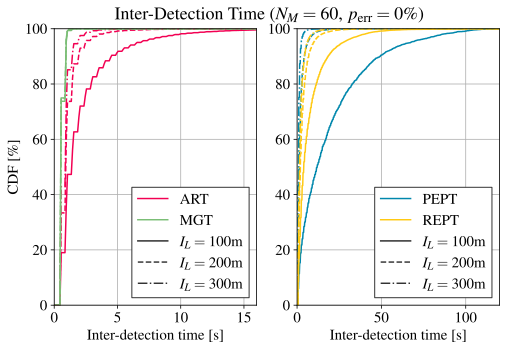

In [78]:
ART_COLOR = color_C2
MGT_COLOR = color_M1
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, axes = plt.subplots(ncols=2, figsize=(8,5))

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(bin_centers, ART_100, '-', color=ART_COLOR, label="ART")
ax1.plot(bin_centers, ART_200, '--', color=ART_COLOR)
ax1.plot(bin_centers, ART_300, '-.', color=ART_COLOR)

ax1.plot(bin_centers, MGT_100, '-', color=MGT_COLOR, label="MGT")
ax1.plot(bin_centers, MGT_200, '--', color=MGT_COLOR)
ax1.plot(bin_centers, MGT_300, '-.', color=MGT_COLOR)
ax1.set_ylabel('CDF [\%]')
ax1.set_xlabel('Inter-detection time [s]')
ax1.grid()

ax1.set_ylim([0,100])
ax1.set_xlim([0,16])

ax1.plot([],[], '-', color='#333', label='$I_L=100$m')
ax1.plot([],[], '--', color='#333', label='$I_L=200$m')
ax1.plot([],[], '-.', color='#333', label='$I_L=300$m')

leg = ax1.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

ax2.plot(bin_centers, PEPT_100, '-', color=PEPT_COLOR, label="PEPT")
ax2.plot(bin_centers, PEPT_200, '--', color=PEPT_COLOR)
ax2.plot(bin_centers, PEPT_300, '-.', color=PEPT_COLOR)

ax2.plot(bin_centers, REPT_100, '-', color=REPT_COLOR, label="REPT")
ax2.plot(bin_centers, REPT_200, '--', color=REPT_COLOR)
ax2.plot(bin_centers, REPT_300, '-.', color=REPT_COLOR)
ax2.set_xlabel('Inter-detection time [s]')
ax2.grid()

ax2.set_ylim([0,100])
ax2.set_xlim([0,120])

ax2.plot([],[], '-', color='#333', label='$I_L=100$m')
ax2.plot([],[], '--', color='#333', label='$I_L=200$m')
ax2.plot([],[], '-.', color='#333', label='$I_L=300$m')

leg = ax2.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

# ax.plot([],[], '-', color='#333', label='$I_L=100$m')
# ax.plot([],[], '--', color='#333', label='$I_L=200$m')
# ax.plot([],[], '-.', color='#333', label='$I_L=300$m')

# ax.set_ylim([0, 100])
# ax.set_xlim([0.005, 155])

# ax.set_ylabel('CCDF [\%]')
# ax.set_xlabel('Hide Time [s]')

# ax.set_xticks([0.01, 0.1,1,10,100])
# ax.set_xticklabels([0.01, 0.1,1,10,100])

# ax.grid()

# plt.title(f'Hide Time ($N_M= {num_malicios}$, $I_L={lying_intensity}$m)')


plt.suptitle(f'Inter-Detection Time ($N_M= {num_malicios}$, $p_\mathrm{{err}} = 0$\%)', y=0.94)

plt.show()

fig.savefig(f"../figures/inter_detection_times_cdf_{num_malicios}_p0_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/inter_detection_times_cdf_{num_malicios}_p0_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)